### 1. 데이터 처리와 분류   

라벨 데이터 처리하기   
sklearn의 train_test_split함수를 이용하여 train, test 분리   

In [2]:
import numpy as np
import os

data_path = os.getenv("HOME")+'/aiffel/speech_recognition/data/speech_wav_8000.npz'
speech_data = np.load(data_path)

print("✅")

✅


위에서 데이터 가져온 후, 아래,랜덤으로 값 가져와보기

In [3]:
import IPython.display as ipd
import random

# 데이터 선택 (랜덤하게 선택하고 있으니, 여러번 실행해 보세요)
rand = random.randint(0, len(speech_data["wav_vals"]))
print("rand num : ", rand)

sr = 8000 # 1초동안 재생되는 샘플의 갯수
data = speech_data["wav_vals"][rand]
print("Wave data shape : ", data.shape)
print("label : ", speech_data["label_vals"][rand])

ipd.Audio(data, rate=sr)

rand num :  20516
Wave data shape :  (8000,)
label :  ['yes']


아래와 같은 Label로 데이터 처리 하기   
['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go' ]   
이 외의 데이터는 'Unknown', 'silence'로 분류

In [4]:
target_list = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']

label_value = target_list
label_value.append('unknown')
label_value.append('silence')

print('LABEL : ', label_value)

new_label_value = dict()
for i, l in enumerate(label_value):
    new_label_value[l] = i
label_value = new_label_value

print('Indexed LABEL : ', new_label_value)

LABEL :  ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'unknown', 'silence']
Indexed LABEL :  {'yes': 0, 'no': 1, 'up': 2, 'down': 3, 'left': 4, 'right': 5, 'on': 6, 'off': 7, 'stop': 8, 'go': 9, 'unknown': 10, 'silence': 11}


int로 이뤄진 index 작업 -> Label data를 더 쉽게 사용하도록 함   
위와 같은 label 텍스트를 숫자로 표시하도록 하는 것

In [5]:
temp = []
for v in speech_data["label_vals"]:
    temp.append(label_value[v[0]])
label_data = np.array(temp)

label_data

array([ 3,  3,  3, ..., 11, 11, 11])

* Sklearn 사용한 데이터 분리 

In [7]:
from sklearn.model_selection import train_test_split

sr = 8000
train_wav, test_wav, train_label, test_label = train_test_split(speech_data["wav_vals"], 
                                                                label_data, 
                                                                test_size=0.1,
                                                                shuffle=True)
print(train_wav)

train_wav = train_wav.reshape([-1, sr, 1]) # add channel for CNN
test_wav = test_wav.reshape([-1, sr, 1])
print("✅")

[[-1.80875053e-04 -5.07311022e-04 -3.26258159e-04 ... -3.53057520e-04
  -2.83964386e-04 -4.09988192e-04]
 [ 3.42323474e-04  4.84821328e-04  4.17482515e-04 ... -6.82026555e-04
  -6.17398589e-04 -5.49003016e-04]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -2.04422351e-04
  -2.46449752e-04 -1.07809785e-04]
 ...
 [ 2.58857581e-05  9.12303731e-05  7.24499841e-05 ...  6.88587606e-05
   6.62026796e-05  5.89697120e-05]
 [ 2.17697909e-03  1.09173823e-04 -6.84403535e-03 ... -1.23884352e-02
  -1.50300711e-02 -1.50968079e-02]
 [ 3.63117713e-03  5.15806908e-03  4.58459719e-04 ...  2.22973456e-03
   2.61751679e-03 -6.93784328e-04]]
✅


나눠진 데이터셋 확인

In [8]:
print("train data : ", train_wav.shape)
print("train labels : ", train_label.shape)
print("test data : ", test_wav.shape)
print("test labels : ", test_label.shape)
print("✅")

train data :  (45558, 8000, 1)
train labels :  (45558,)
test data :  (5062, 8000, 1)
test labels :  (5062,)
✅



### 2. 학습을 위한 하이퍼파라미터 설정   

체크포인트 저장을 위한 체크포인트 경로 설정

In [9]:
batch_size = 32
max_epochs = 10

# the save point
checkpoint_dir = os.getenv('HOME')+'/aiffel/speech_recognition/models/wav'

checkpoint_dir

'/home/ssac8/aiffel/speech_recognition/models/wav'

### 3. 데이터셋 구성   

* tf.data.Dataset을 이용한 데이터셋 구성   
tensorflow의 데이터셋 관리 패키지는 데이터셋 전처리, 배치처리 등을 쉽게 하게 해줌!   

from_tensor_slices 함수에 return 받길 원하는 데이터를 튜플 (data, label) 형태로 넣어서 사용   

* map과 batch를 이용한 데이터 전처리   

주의 : waveform을 spectrogram으로 변환하기 위해 추가로 사용하는 메모리 때문에 이후 메모리 부족 현상을 겪게 될수도 있습니다.   

tf.data.Dataset이 생성된 이후, 아래 예시와 같이 wav 데이터나 spectrogram 데이터를 담아둔 메모리 버퍼를 비워 주면 도움이 됩니다.   

del speech_data   

del spec_data   

아래는 map함수에 넘겨줄 데이터 전처리 함수 작성 한 것 

In [10]:
def one_hot_label(wav, label):
    label = tf.one_hot(label, depth=12)
    return wav, label
print("✅")

✅


tf.data.dataset 함수 구성하기 

In [12]:
import tensorflow as tf

# for train
train_dataset = tf.data.Dataset.from_tensor_slices((train_wav, train_label))
train_dataset = train_dataset.map(one_hot_label)
train_dataset = train_dataset.repeat().batch(batch_size=batch_size)
print(train_dataset)

# for test
test_dataset = tf.data.Dataset.from_tensor_slices((test_wav, test_label))
test_dataset = test_dataset.map(one_hot_label)
test_dataset = test_dataset.batch(batch_size=batch_size)
print(test_dataset)
print("✅")

<BatchDataset shapes: ((None, 8000, 1), (None, 12)), types: (tf.float32, tf.float32)>
<BatchDataset shapes: ((None, 8000, 1), (None, 12)), types: (tf.float32, tf.float32)>
✅



### 4. 2차원 Spectrogram 데이터를 처리하는 모델 구성   

* 2차원 Spectrogram 데이터의 시간축 방향으로 Conv1D layer를 적용, 혹은 Conv2D layer를 적용 가능   

batchnorm, dropout, dense layer 등을 이용   

* 12개의 단어 class를 구분하는 loss를 사용하고 Adam optimizer를 사용   

* 모델 가중치를 저장하는 checkpoint callback 함수 추가   

다양한 모델의 실험을 진행해 보시기 바랍니다.   


pip install librosa를 통해 FFT 관련 라이브러리인 librosa 설치 후 적용   

In [15]:
import librosa

def wav2spec(wav, fft_size=258): # spectrogram shape을 맞추기위해서 size 변형
    D = np.abs(librosa.stft(wav, n_fft=fft_size))
    return D
print("✅")

✅


In [19]:
# 위에서 뽑았던 sample data 넣기 
spec = wav2spec(data)
print("Waveform shape : ",data.shape)
print("Spectrogram shape : ",spec.shape)

Waveform shape :  (8000,)
Spectrogram shape :  (130, 126)


Spectogram 뽑기 

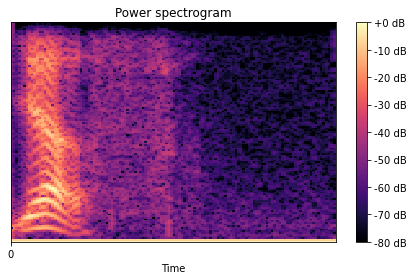

In [22]:
import matplotlib.pyplot as plt
import librosa.display

librosa.display.specshow(librosa.amplitude_to_db(spec, ref=np.max), x_axis='time')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.xticks(range(0, 1))
plt.tight_layout()
plt.show()

*conv, batch norm, dropout, dense layer를 사용한 Conv1D layer 모델 구성! 

In [23]:
from tensorflow.keras import layers

input_tensor = layers.Input(shape=(sr, 1))

x = layers.Conv1D(32, 9, padding='same', activation='relu')(input_tensor)
x = layers.Conv1D(32, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model_wav = tf.keras.Model(input_tensor, output_tensor)

model_wav.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 8000, 1)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 8000, 32)          320       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 8000, 32)          9248      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 4000, 32)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 4000, 64)          18496     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 4000, 64)          36928     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 2000, 64)          0     

[Loss]   
* Loss 사용 후, Adam Otimizer로 최소의 Loss 값 구하기 

In [24]:
optimizer=tf.keras.optimizers.Adam(1e-4)
model_wav.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['accuracy'])
print("✅")

✅


[Training]   
* Model.fit 함수 이용할 때, callback 함수 이용해서 학습 중간 중간 원하는 동작 하도록 설정.   
* Model Checkpoint callback은 모델 학습 진행 & fit 함수 내에서 다양한 인자를 지정해서 모니터하고 동작을 하게 할 수 있음.   


In [25]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)
print("✅")

✅


아래는 모델 학습 코드!   
위에도 모델 구조와 Training 구조를 짰다면, 여기서는 실질적으로 학습이 시작되는 구간   


In [28]:
#30분 내외 소요 (메모리 사용량에 주의해 주세요.)
history_wav = model_wav.fit(train_dataset, epochs=max_epochs,
                    steps_per_epoch=len(train_wav) // batch_size,
                    validation_data=test_dataset,
                    validation_steps=len(test_wav) // batch_size,
                    callbacks=[cp_callback]
                    )
print("✅")

Epoch 1/10
1423/1423 [==============================] - ETA: 0s - loss: 0.7402 - accuracy: 0.7728
Epoch 00001: val_loss improved from 0.94407 to 0.63482, saving model to /home/ssac8/aiffel/speech_recognition/models/wav
1423/1423 [==============================] - 143s 100ms/step - loss: 0.7402 - accuracy: 0.7728 - val_loss: 0.6348 - val_accuracy: 0.7998
Epoch 2/10
1423/1423 [==============================] - ETA: 0s - loss: 0.5350 - accuracy: 0.8396
Epoch 00002: val_loss improved from 0.63482 to 0.53372, saving model to /home/ssac8/aiffel/speech_recognition/models/wav
1423/1423 [==============================] - 144s 101ms/step - loss: 0.5350 - accuracy: 0.8396 - val_loss: 0.5337 - val_accuracy: 0.8339
Epoch 3/10
1423/1423 [==============================] - ETA: 0s - loss: 0.3885 - accuracy: 0.8883
Epoch 00003: val_loss improved from 0.53372 to 0.47435, saving model to /home/ssac8/aiffel/speech_recognition/models/wav
1423/1423 [==============================] - 144s 101ms/step - loss: 


### 5. 학습 후, 학습이 어떻게 진행됐는지 그래프로 출력   

loss, accuracy를 그래프로 표현   

[학습결과 Plot]   
* Model.fit 함수로 학습 동안의 결과를 return.   
* Fit 함수에서 전달 받은 Loss와 Accuracy 값을 이용해 모델의 학습 질을 확인 가능!   
* Note:Overfitting이 일어날때 Fit함수는 이를 방지하는데 사용됨!   

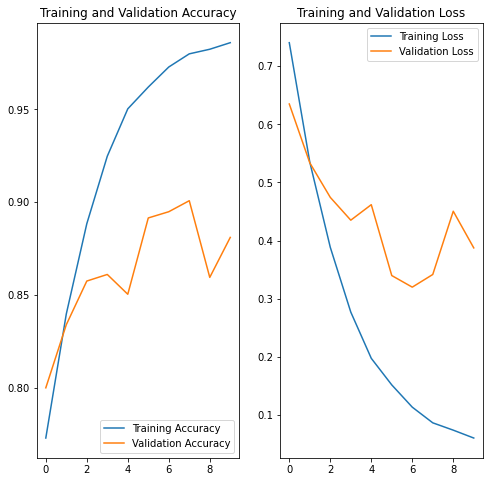

✅


In [29]:
import matplotlib.pyplot as plt

acc = history_wav.history['accuracy']
val_acc = history_wav.history['val_accuracy']

loss=history_wav.history['loss']
val_loss=history_wav.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
print("✅")

### 6. Test dataset을 이용해서 모델의 성능을 평가   

[Evaluation]   
* Checkpoint callback 함수가 저장한 weight 다시 불러서 테스트 준비 
* Test dataset을 통해 모델의 성능 평가!   


In [30]:
model_wav.load_weights(checkpoint_dir)
print("✅")

✅


In [31]:
results = model_wav.evaluate(test_dataset)
print("✅")

159/159 [==============================] - 11s 67ms/step - loss: 0.3197 - accuracy: 0.8949
✅


In [33]:
# loss
print("loss value: {:.3f}".format(results[0]))
# accuracy
print("accuracy value: {:.4f}%".format(results[1]*100))
print("✅")

loss value: 0.320
accuracy value: 89.4903%
✅


[마지막 Model Test]   
* 직접 오디오 파일을 가지고 와서 들어보기 
* Prediction된 값과 결과를 직접 비교! 

In [36]:
inv_label_value = {v: k for k, v in label_value.items()}
batch_index = np.random.choice(len(test_wav), size=1, replace=False)

batch_xs = test_wav[batch_index]
batch_ys = test_label[batch_index]
y_pred_ = model_wav(batch_xs, training=False)

print("label : ", str(inv_label_value[batch_ys[0]]))

ipd.Audio(batch_xs.reshape(8000,), rate=8000)

label :  on


In [38]:
if np.argmax(y_pred_) == batch_ys[0]:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Correct!)')
else:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Incorrect!)')
print("✅")

y_pred: on(Correct!)
✅
